## Lab 2: final challenges

__Вам предлагается решить задачу классификации сигналов или задачу классификации изображений. Или обе ;)__

__Выполнение этих заданий не является обязательным, но позитивно повлияет на вашу итоговую оценку. Успехов!__


### Part 4. HAR classification with raw data (2+ points)
__Disclaimer__: Это опциональная часть задания. Здесь придется экспериментировать, подбирать оптимальную структуру сети для решения задачи и активно искать подскзаки в сети.


Данное задание составлено на основе данного [поста](https://burakhimmetoglu.com/2017/08/22/time-series-classification-with-tensorflow/). С помощью вручную сгенерированных фичей и классических подходов задача распознования движений была решена с точностью 96%. 

Также будет полезным изучить [вот этот](https://github.com/healthDataScience/deep-learning-HAR), а так же [вот этот репозиторий](https://github.com/guillaume-chevalier/LSTM-Human-Activity-Recognition), где к данной задаче рассматривается несколько подходов.

In [ ]:
import numpy as np
import matplotlib.pyplot as plt
import pandas as pd
import math
import pylab
import warnings as w
import os

%matplotlib inline

In [ ]:
import matplotlib
matplotlib.rcParams.update({'font.size':14})

Вернемся к задаче классификации движений на основе [данных](https://archive.ics.uci.edu/ml/datasets/Human+Activity+Recognition+Using+Smartphones) из репозитория UCI ([прямая ссылка на скачивание](https://archive.ics.uci.edu/ml/machine-learning-databases/00240/UCI%20HAR%20Dataset.zip)). 

В этот раз будем работать с исходными, а не предобработанными данными. Данные представляют собой сигналы с гироскопа и акселерометра, закрепленного на теле человека. Каждому семплу соотвествует 9 связанных временных рядов.

В начале приведена визуализация данных на основе PCA над вручную сгенерированными признаками. Для отрисовки графиков (цвет и легенда) нам также понадобятся метки классов.

In [ ]:
X_train_with_engineered_features = np.genfromtxt(os.path.join("UCI HAR Dataset", "train", "X_train.txt"))
y_train = np.genfromtxt(os.path.join("UCI HAR Dataset", "train", "y_train.txt"))

y_train_list = list(y_train)
X_unique = np.array([X_train_with_engineered_features[y_train_list.index(l)]
                             for l in sorted(list(set(y_train)))])

legend_labels = ["WALKING", "WALKING.UP", "WALKING.DOWN", "SITTING", "STANDING", "LAYING"]
colors_list = ['red', 'blue', 'green', 'orange', 'cyan', 'magenta']
mapped_colors = [colors_list[int(i)-1] for i in y_train]

from sklearn.decomposition import PCA
pca = PCA()

X_train_pca = pca.fit_transform(X_train_with_engineered_features)

plt.figure(figsize=(15,10))
pylab.scatter(X_train_pca[:, 0], X_train_pca[:, 1],
             c=mapped_colors)
plt.grid()
for idx, x in enumerate(pca.transform(X_unique)):
    plt.scatter(x[0], 
                x[1], 
                c=colors_list[idx], 
                label=legend_labels[idx])
plt.xlabel('First principal component')
plt.ylabel('Second principal component')
plt.legend()

#### Предобработка данных
Предобработка сделана за нас автором [данного репозитория](https://github.com/guillaume-chevalier/LSTM-Human-Activity-Recognition). Будьте осторожны с путями.

In [ ]:
# Useful Constants

# Those are separate normalised input features for the neural network
INPUT_SIGNAL_TYPES = [
    "body_acc_x_",
    "body_acc_y_",
    "body_acc_z_",
    "body_gyro_x_",
    "body_gyro_y_",
    "body_gyro_z_",
    "total_acc_x_",
    "total_acc_y_",
    "total_acc_z_"
]

# Output classes to learn how to classify
LABELS = [
    "WALKING", 
    "WALKING_UPSTAIRS", 
    "WALKING_DOWNSTAIRS", 
    "SITTING", 
    "STANDING", 
    "LAYING"
]

DATA_PATH = "./"

DATASET_PATH = DATA_PATH + "UCI HAR Dataset/"
print("\n" + "Dataset is now located at: " + DATASET_PATH)

TRAIN = "train/"
TEST = "test/"


# Load "X" (the neural network's training and testing inputs)

def load_X(X_signals_paths):
    X_signals = []
    
    for signal_type_path in X_signals_paths:
        file = open(signal_type_path, 'r')
        # Read dataset from disk, dealing with text files' syntax
        X_signals.append(
            [np.array(serie, dtype=np.float32) for serie in [
                row.replace('  ', ' ').strip().split(' ') for row in file
            ]]
        )
        file.close()
    
    return np.transpose(np.array(X_signals), (1, 2, 0))

X_train_signals_paths = [
    os.path.join(*[DATASET_PATH, TRAIN, "Inertial Signals/", signal+"train.txt"]) for signal in INPUT_SIGNAL_TYPES
]
X_test_signals_paths = [
    os.path.join(*[DATASET_PATH, TEST, "Inertial Signals/", signal+"test.txt"]) for signal in INPUT_SIGNAL_TYPES
]

X_train = load_X(X_train_signals_paths)
X_test = load_X(X_test_signals_paths)


# Load "y" (the neural network's training and testing outputs)

def load_y(y_path):
    file = open(y_path, 'r')
    # Read dataset from disk, dealing with text file's syntax
    y_ = np.array(
        [elem for elem in [
            row.replace('  ', ' ').strip().split(' ') for row in file
        ]], 
        dtype=np.int32
    )
    file.close()
    
    # Substract 1 to each output class for friendly 0-based indexing 
    return y_ - 1

y_train_path = os.path.join(DATASET_PATH, TRAIN, "y_train.txt")
y_test_path = os.path.join(DATASET_PATH, TEST, "y_test.txt")

y_train = load_y(y_train_path)
y_test = load_y(y_test_path)

In [ ]:
# Input Data 

training_data_count = len(X_train)  # 7352 training series (with 50% overlap between each serie)
test_data_count = len(X_test)  # 2947 testing series
n_steps = len(X_train[0])  # 128 timesteps per series
n_input = len(X_train[0][0])  # 9 input parameters per timestep


# LSTM Neural Network's internal structure

n_hidden = 32 # Hidden layer num of features
n_classes = 6 # Total classes (should go up, or should go down)


# Some debugging info

print("Some useful info to get an insight on dataset's shape and normalisation:")
print("(X shape, y shape, every X's mean, every X's standard deviation)")
print(X_test.shape, y_test.shape, np.mean(X_test), np.std(X_test))
print("The dataset is therefore properly normalised, as expected, but not yet one-hot encoded.")

#### Построение сети и эксперименты. (100% +)

__Ваша задача - построить сеть, которая решит задачу классификации с точностью (`accuracy`) не менее 86%.__
Разбалловка следующая:
* $=$86% - 2 points
* $>=$89% - 2.5 points
* $>=$91% - 3 points


__Warning!__ В сети существует несколько решений данной задачи с использованием различных фреймворков. При проверке это будет учитываться, так что свое решение нужно будет объяснить. Пожалуйста, не копируйте бездумно код, такие задания будут оценены 0 баллов. Если задача не решается - можете обратиться к заданию по классификации изображений.

После выполнения задания заполните небольшой отчет об экспериментах вида "Я пробовал(а) ... подходы и получил(а) ... результаты. Наконец, после N+1 чашки кофе/бессонной ночи у меня получилось, и весь секрет был в ..."

In [ ]:
# Your experiments here

### Part 5. Dogs classification (2+ points)
__Disclaimer__: Это опциональная часть задания. Здесь придется экспериментировать, подбирать оптимальную структуру сети для решения задачи и активно искать подскзаки в сети.

Предлагаем вам решить задачу классификации пород собак. Вы можете обучить сеть с нуля или же воспользоваться методом fine-tuning'а. Полезная ссылка на [предобученные модели](https://pytorch.org/docs/stable/torchvision/models.html).

Данные можно скачать [отсюда](https://www.dropbox.com/s/vgqpz2f1lolxmlv/data.zip?dl=0). Датасет представлен 50 классами пород собак, которые можно найти в папке train в соответствующих директориях. При сдаче данной части задания вместе с ноутбуком необходимо отправить .csv-файл с предсказаниями классов тестовой выборки в формате: <имя изображения>,<метка класса> по одному объекту на строку. Ниже приведите код ваших экспериментов и короткий вывод по их результатам.

Будут оцениваться качество классификации (accuracy) на тестовой выборке (2 балла) и проведенные эксперименты (1 балл).
Разбалловка следующая:
* $>=$93% - 2 points
* $>=$84% - 1.5 points
* $>=$70% - 0.75 points

In [1]:
from __future__ import print_function, division

import os
import random
from argparse import Namespace
import shutil

import torch
import torchvision
import torchvision.transforms as transforms
# import torch.utils.data as data
from torchvision import datasets

import matplotlib.pyplot as plt
import numpy as np

import torch
import torch.nn as nn
import torch.optim as optim
from torch.optim import lr_scheduler
from torch.utils.data import ConcatDataset
import numpy as np
import torchvision
from torchvision import datasets, models, transforms
from torchvision.utils import make_grid
import torchsummary
import matplotlib.pyplot as plt
import time
import os
import copy
from tqdm import tqdm
import logging
import logging.config
import yaml

plt.ion()   # interactive mode

%matplotlib inline

In [2]:
TRAIN_DATA = os.path.join('data', 'train')
TEST_DATA = os.path.join('data', 'test')
VALIDATE_DATA = os.path.join('data', 'validate')
CROSS_VAL_DATA = os.path.join('data', 'cross_val_folder')
NONSPLITTED_DATA = os.path.join('data', 'nonsplitted_data')
BATCH_SIZE = 128
TEST_SIZE = 0.3
CLASS_COUNT = 50
K_FOLD = 3
LOG_CONFIG_FILE = os.path.join("logs", "log_config.yml")
LOG_INFO_FILE = os.path.join("logs", "lab_2_part_5.info")

In [3]:
def seed_init(x=0):
    '''Init random seed'''
    seed = 42 + x
    random.seed(seed)
    np.random.seed(seed)
    torch.manual_seed(seed)

Настроим логоирование, чтобы не засорять ноутбук выводом функций. Всю вспомогалельную информацию будем перенаправлять в логи.

In [4]:
logger = logging.getLogger("Lab2_DL_parts_4_and_5_optional")
logger.setLevel(logging.INFO)
logging_file_handler = logging.FileHandler(LOG_INFO_FILE)
logging_file_handler.setLevel(logging.INFO)
logging_formatter = logging.Formatter("%(asctime)s %(levelname)s %(message)s")
logging_file_handler.setFormatter(logging_formatter)
logger.addHandler(logging_file_handler)
seed_init()
device = 'cuda:0' if torch.cuda.is_available() else 'cpu'
device

'cuda:0'

Далее реализуем функцию для вывода количества элементов обучающей и тестовой выборок для разных категорий

In [5]:
def print_tree():
    '''Get data folder tree'''
    print('data:')
    train_count = sum([ len(os.listdir(os.path.join(TRAIN_DATA, subdir))) for subdir in os.listdir(TRAIN_DATA) ])
    test_count = sum([ len(os.listdir(os.path.join(TEST_DATA, subdir))) for subdir in os.listdir(TEST_DATA) ])
    validate_count = len(os.listdir(os.path.join(VALIDATE_DATA, '0'))) if os.path.exists(VALIDATE_DATA) else 0
    nonsplitted_count = sum([ len(os.listdir(os.path.join(NONSPLITTED_DATA, subdir))) for subdir in os.listdir(NONSPLITTED_DATA) ])
    print(f"\ttrain: {train_count}\n\ttest: {test_count}\n\tvalidate: {validate_count}\n\tnonsplitted_data: {nonsplitted_count}")
    
    if os.path.exists(CROSS_VAL_DATA):
        print(f"\tcross_val_folder:")
        for fold_idx in range(K_FOLD):
            train_source = os.path.join(CROSS_VAL_DATA, f'fold_{fold_idx}', 'train')
            test_source = os.path.join(CROSS_VAL_DATA, f'fold_{fold_idx}', 'test')
            current_fold_train_count = sum([ len(os.listdir(os.path.join(train_source, str(subdir)))) for subdir in range(CLASS_COUNT) ])
            current_fold_test_count = sum([ len(os.listdir(os.path.join(test_source, str(subdir)))) for subdir in range(CLASS_COUNT) ])
            print(f"\t\tfold_{fold_idx}:")
            print(f"\t\t\ttrain: {current_fold_train_count}")
            print(f"\t\t\ttest: {current_fold_test_count}")
    else:
        print(f"\tcross_val_folder: 0")

По умолчанию предоставлены только данные для обучения и данные для предсказания. Разделим данные на следующие категории
- `train` и `test` для обучения и тестирования модели на различных параметрах
- `cross_val_folder` - разбиение данных на фолды для кросс валидации
- `nonsplitted_data` - для обучения финальной модели на всей выборке
- `validate` - данные, для которых нужно предсказать метки

Функция ниже создает нужную для обучения и тестирования структуру папок и файлов

In [6]:
# Split data if not splitted yet
if not os.path.exists(os.path.join("data", "validate")):
    # Copy nonsplitted data
    source = os.path.join('data', 'train')
    target = NONSPLITTED_DATA
    shutil.copytree(source, target)

    # Create folders with data for CrossVal
    crossval_folder_names = [(os.path.join(CROSS_VAL_DATA, f'fold_{i}', 'train'), os.path.join(CROSS_VAL_DATA, f'fold_{i}', 'test')) for i in range(K_FOLD)]
    file_names_per_each_class = [os.listdir(os.path.join(TRAIN_DATA, str(i))) for i in range(CLASS_COUNT)]
    
    for fold_idx, (train_folder_name, test_folder_name) in enumerate(crossval_folder_names):
        for class_idx, file_names_lst in enumerate(file_names_per_each_class):
            current_test_size = int(len(file_names_lst) // K_FOLD + 1)
            current_class_train_folder_name = os.path.join(train_folder_name, str(class_idx))
            current_class_test_folder_name = os.path.join(test_folder_name, str(class_idx))
            os.makedirs(current_class_train_folder_name)
            os.makedirs(current_class_test_folder_name)
            cut_begin_idx = fold_idx * current_test_size
            cut_end_idx = (fold_idx + 1) * current_test_size
            
            for filename in file_names_lst[cut_begin_idx:cut_end_idx]:
                source = os.path.join(TRAIN_DATA, str(class_idx), filename)
                target = os.path.join(CROSS_VAL_DATA, f'fold_{fold_idx}', 'test', str(class_idx), filename)
                shutil.copy(source, target)
                
            for filename in file_names_lst[:cut_begin_idx]:
                source = os.path.join(TRAIN_DATA, str(class_idx), filename)
                target = os.path.join(CROSS_VAL_DATA, f'fold_{fold_idx}', 'train', str(class_idx), filename)
                shutil.copy(source, target)
                
            for filename in file_names_lst[cut_end_idx:]:
                source = os.path.join(TRAIN_DATA, str(class_idx), filename)
                target = os.path.join(CROSS_VAL_DATA, f'fold_{fold_idx}', 'train', str(class_idx), filename)
                shutil.copy(source, target)
    
    # Split on train and test
    os.rename(TEST_DATA, VALIDATE_DATA)

    for dir_name in os.listdir(TRAIN_DATA):
        subfolder = os.path.join(TRAIN_DATA, dir_name)
        files_in_subfolder = os.listdir(subfolder)
        test_files_count = int(len(files_in_subfolder) * TEST_SIZE)
        files_for_moving_to_test = random.sample(files_in_subfolder, k=test_files_count)
        os.makedirs(os.path.join(TEST_DATA, dir_name))

        for file_name in files_for_moving_to_test:
            source_name = os.path.join(subfolder, file_name)
            target_name = os.path.join(TEST_DATA, dir_name, file_name)
            shutil.move(source_name, target_name)
            
print_tree()

data:
	train: 5041
	test: 2125
	validate: 1503
	nonsplitted_data: 7166
	cross_val_folder:
		fold_0:
			train: 4744
			test: 2422
		fold_1:
			train: 4744
			test: 2422
		fold_2:
			train: 4844
			test: 2322


Разделим случайным образом данные на train и test. Также добавим в тренировочные данные аугментации и добавим новые данные в обучающую выборку для повышения обоющающей способности. Тестовые и валидационные данные аугментации не подвергаются.

In [40]:
class_names = (str(i) for i in range(CLASS_COUNT))

rand_augmenter = transforms.RandAugment()
AUGMENT_COUNT = 4

transform_dict = {
    'train': transforms.Compose(
        [
            transforms.Resize((224, 224)),
            transforms.RandomHorizontalFlip(p=0.5),
            transforms.RandAugment(),
            transforms.ToTensor(),
            transforms.Normalize((0.5, 0.5, 0.5), (0.5, 0.5, 0.5)),
            # transforms.Normalize(mean=[0.485, 0.456, 0.406],
            #                   std=[0.229, 0.224, 0.225]),
         ]
    ),
    'augment': transforms.Compose(
        [
            transforms.Resize((224, 224)),
            transforms.RandomHorizontalFlip(p=0.9),
            transforms.RandAugment(),
            transforms.ToTensor(),
            transforms.Normalize((0.5, 0.5, 0.5), (0.5, 0.5, 0.5)),
        ]
    ),
    'test': transforms.Compose(
        [
            transforms.Resize((224, 224)),
            transforms.ToTensor(),
            transforms.Normalize((0.5, 0.5, 0.5), (0.5, 0.5, 0.5)),
            # transforms.Normalize(mean=[0.485, 0.456, 0.406],
            #                      std=[0.229, 0.224, 0.225]),
        ]
    )
}

train_data = datasets.ImageFolder(root=TRAIN_DATA, transform=transform_dict['train'])
test_data = datasets.ImageFolder(root=TEST_DATA, transform=transform_dict['test'])
augmented_data = datasets.ImageFolder(root=TRAIN_DATA, transform=transform_dict['augment'])
train_and_augmented_data = ConcatDataset([train_data, augmented_data])
nonsplitted_data = datasets.ImageFolder(root=NONSPLITTED_DATA, transform=transform_dict['train'])
augmented_nonsplitted_data = datasets.ImageFolder(root=NONSPLITTED_DATA, transform=transform_dict['augment'])
augmented_and_nonsplitted_data = ConcatDataset([nonsplitted_data, augmented_nonsplitted_data])
validate_data = datasets.ImageFolder(root=VALIDATE_DATA, transform=transform_dict['test'])

print(f"Train size: {len(train_data)}")
print(f"Test size: {len(test_data)}")
print(f"Augmented size: {len(augmented_data)}")
print(f"Joined augmented and train size: {len(train_and_augmented_data)}")
print(f"All train data + augmentation size: {len(augmented_and_nonsplitted_data)}")
print(f"Validate size: {len(validate_data)}")

train_loader = torch.utils.data.DataLoader(train_and_augmented_data, batch_size=BATCH_SIZE, shuffle=True, drop_last=False, num_workers=4, worker_init_fn=seed_init)
test_loader = torch.utils.data.DataLoader(test_data, batch_size=BATCH_SIZE, shuffle=True, drop_last=False, num_workers=4, worker_init_fn=seed_init)
nonsplitted_loader = torch.utils.data.DataLoader(augmented_and_nonsplitted_data, batch_size=BATCH_SIZE, shuffle=True, drop_last=False, num_workers=4, worker_init_fn=seed_init)
validate_loader = torch.utils.data.DataLoader(validate_data, batch_size=BATCH_SIZE, shuffle=False, drop_last=False, num_workers=4, worker_init_fn=seed_init)

Train size: 5041
Test size: 2125
Augmented size: 5041
Joined augmented and train size: 10082
All train data + augmentation size: 14332
Validate size: 1503


In [8]:
print(f"Train size: {len(train_loader.dataset)}\nTest size: {len(test_loader.dataset)}")
dataloaders = {
    'train': train_loader,
    'test': test_loader,
}
dataset_sizes = {
    'train': len(train_loader.dataset),
    'test': len(test_loader.dataset),
}

Train size: 10082
Test size: 2125


Ниже приведены примеры данных из обучающей выборки:

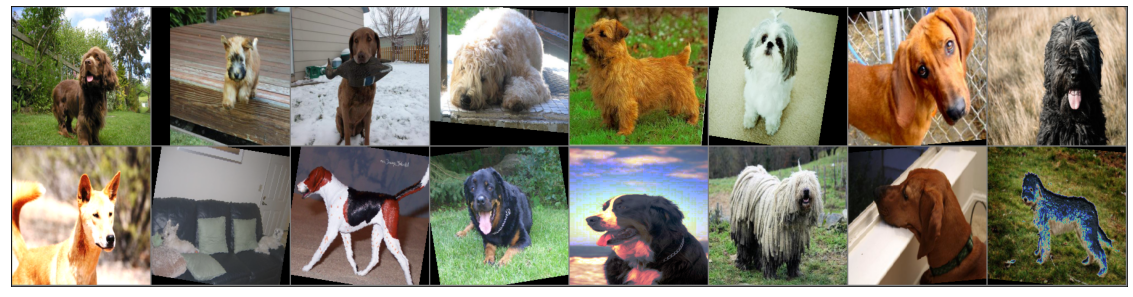

In [9]:
def show(data_loader):
    _, (images, foo) = next(enumerate(data_loader))
    # print(images[:10, :, :, :].shape)
    npimg = make_grid(images[:16, :, :, :], normalize=True, pad_value=.5).numpy()
    fig, ax = plt.subplots(figsize=((20, 10)))
    ax.imshow(np.transpose(npimg, (1, 2, 0)))
    plt.setp(ax, xticks=[], yticks=[])
    plt.show()
    
show(train_loader)

Создаем собственный класс для работы с предобученными моделями. В ходе исследования были рассмотрены различные модели ResNet и AlexNet. Чтобы не копировать код для работы с этими моделями, а лишь использовать единый интерфейс для обучения и тестирования, создается данный класс.

In [35]:
class Model:
    """
    Image classifier
    
    """
    
    def __init__(self, hyperparams: Namespace, dataloaders: dict):
        # logger.debug("Init Model class object")
        self.hyperparams = hyperparams
        self.dataloaders = dataloaders
        self.model = model = hyperparams.model
        self.epoch_count = hyperparams.epoch_count
        self.best_model = hyperparams.model
        
        if hyperparams.finetune:
            for param in self.model.parameters():
                param.requires_grad = False

        if 'ResNet' in str(type(model)):
            num_features = model.fc.in_features
            self.model.fc = nn.Linear(num_features, CLASS_COUNT)
        elif 'AlexNet' in str(type(model)):
            num_features = model.classifier[6].in_features
            model.classifier[6] = nn.Linear(num_features, CLASS_COUNT)
        else:
            raise NotImplementedError()

        self.model = self.model.to(device)

        self.criterion = nn.CrossEntropyLoss()

        # Observe that all parameters are being optimized
        self.optimizer = optim.SGD(
            self.model.parameters(),
            lr=hyperparams.lr,
            momentum=hyperparams.momentum
        )

        # Decay LR by a factor of 0.1 every 7 epochs
        self.scheduler = lr_scheduler.StepLR(
            self.optimizer, 
            step_size=hyperparams.step_size,
            gamma=hyperparams.gamma
        )

    def train(self, test_phase=True):
        since = time.time()

        best_model_wts = copy.deepcopy(self.model.state_dict())
        best_acc = 0.0
        best_epoch = None
        train_loss_hist = []
        test_loss_hist = []
        train_acc_hist = []
        test_acc_hist = []
        dataset_sizes = {
            'train': len(self.dataloaders['train'].dataset),
            'test': len(self.dataloaders['test'].dataset),
        }
        if test_phase:
            phase_lst = ['train', 'test']
        else:
            phase_lst = ['train']

        print_params = vars(self.hyperparams)
        print_params['model'] = type(self.hyperparams.model)
        logger.info(f"[TRAIN LOOP] Start train model {type(self.model)}")
        logger.info(f"[TRAIN LOOP] Training params: {print_params}")
        logger.info(f"[TRAIN LOOP] Train size: {len(self.dataloaders['train'].dataset)}, Test size: {len(self.dataloaders['test'].dataset)}")

        for epoch in tqdm(range(self.epoch_count)):
            # print('Epoch {}/{}'.format(epoch, num_epochs - 1))
            # print('-' * 10)

            for phase in phase_lst:
                if phase == 'train':
                    self.model.train()
                else:
                    self.model.eval()

                running_loss = 0.0
                running_corrects = 0

                # Iterate over data.
                for inputs, labels in self.dataloaders[phase]:
                    inputs = inputs.to(device)
                    labels = labels.to(device)

                    # zero the parameter gradients
                    self.optimizer.zero_grad()

                    # forward
                    # track history if only in train
                    with torch.set_grad_enabled(phase == 'train'):
                        outputs = self.model(inputs)
                        _, preds = torch.max(outputs, 1)
                        loss = self.criterion(outputs, labels)

                        # backward + optimize only if in training phase
                        if phase == 'train':
                            loss.backward()
                            self.optimizer.step()

                    # statistics
                    running_loss += loss.item() * inputs.size(0)
                    running_corrects += torch.sum(preds == labels.data)
                if phase == 'train':
                    self.scheduler.step()

                epoch_loss = running_loss / dataset_sizes[phase]
                epoch_acc = running_corrects.double() / dataset_sizes[phase]

                # print('{} Loss: {:.4f} Acc: {:.4f}'.format(phase, epoch_loss, epoch_acc))
                logger.info('[TRAIN LOOP] Epoch: {}/{}\tPhase: {}\tLoss: {:.4f}\tAcc: {:.4f}'.format(epoch, self.epoch_count, phase, epoch_loss, epoch_acc))

                # deep copy the model
                if phase == 'test' and epoch_acc > best_acc:
                    best_acc = epoch_acc.detach().item()
                    best_model_wts = copy.deepcopy(self.model.state_dict())
                    best_epoch = epoch

                if phase == 'train':
                    train_loss_hist.append(epoch_loss)
                    train_acc_hist.append(epoch_acc)
                else:
                    test_loss_hist.append(epoch_loss)
                    test_acc_hist.append(epoch_acc)

            # print()

        time_elapsed = time.time() - since
        print('Training complete in {:.0f}m {:.0f}s'.format(time_elapsed // 60, time_elapsed % 60))
        print('Best test Acc: {:4f}'.format(best_acc))
        logger.info('[TRAIN LOOP] Training complete in {:.0f}m {:.0f}s'.format(time_elapsed // 60, time_elapsed % 60))
        if test_phase:
            logger.info('[TRAIN LOOP] Best test Acc: {:4f} on epoch: {}'.format(best_acc, best_epoch))
            self.best_model.load_state_dict(best_model_wts)

        loss_and_acc_stat = {
            'train_loss': train_loss_hist,
            'train_acc': train_acc_hist,
            'test_loss': test_loss_hist,
            'test_acc': test_acc_hist,
            'best_acc': best_acc,
            'best_epoch': best_epoch,
            'time': time_elapsed,
        }

        logger.info(f"[TRAIN LOOP] End train model {type(self.model)}")

        return self, loss_and_acc_stat
    
    def predict(self, validate_loader, use_best_model = True):
        '''Predict labels by given Dataloader'''
        logger.info("[PREDICT] Start predict")
        if use_best_model:
            model = self.best_model
        else:
            model = self.model
        
        model.eval()
        preds_lst = []
        
        with torch.no_grad():
            for _, (inputs, labels) in enumerate(validate_loader):
                inputs = inputs.to(device)
                labels = labels.to(device)
                outputs = model(inputs)
                _, batch_preds = torch.max(outputs, 1)
                preds_lst += list(batch_preds)
        
        logger.info(f"[PREDICT] Prediction done. Predicted: {len(preds_lst)} items")
        
        return preds_lst

Ниже исследуются различные модели архитектуры ResNet и AlexNet. В зависимости от их качества на тестовой выборке будет принято решение об использовании той или иной архитектуры.

In [11]:
hyperparams = Namespace()
hyperparams.finetune = True
hyperparams.lr = 0.0008
hyperparams.momentum = 0.9
hyperparams.step_size = 7
hyperparams.gamma = 0.1
hyperparams.epoch_count = 10

base_models_lst = [models.resnet101(pretrained=True), models.resnet152(pretrained=True), models.alexnet(pretrained=True)]
base_model_names_lst = ['resnet101', 'resnet152', 'alexnet']
logger.info(f"[GRID SEARCH] Start grid search optimal params: pretrained model choice from {base_model_names_lst}")
grid_search_through_base_models_report = {}
best_acc = 0
best_model_name = None

start_time = time.time()

for base_model, model_name in zip(base_models_lst, base_model_names_lst):
    hyperparams.model = base_model
    hyperparams.log_comment = f"{model_name} with RandHorizontalFlip(p=0.9) and RandAugment transform applied to original dataset (EXPANDED train dataset)"
    model = Model(hyperparams, dataloaders)
    _, train_stat = model.train()
    
    if train_stat['best_acc'] > best_acc:
        best_acc = train_stat['best_acc']
        best_model_name = model_name
    
    grid_search_through_base_models_report[model_name] = train_stat
    logger.info(f"[GRID SEARCH] Model {model_name} best acc: {train_stat['best_acc']}")
    
evaluate_time = time.time() - start_time
grid_search_through_base_models_report['time'] = evaluate_time
logger.info(f"[GRID SEARCH] Finished in {evaluate_time // 60}m {int(evaluate_time % 60)}s. Best model: {best_model_name} with acc: {best_acc}")
print(f"Finished in {evaluate_time // 60}m {int(evaluate_time % 60)}s. Best model: {best_model_name} with acc: {best_acc}")

100%|██████████| 10/10 [06:19<00:00, 37.97s/it]


Training complete in 6m 20s
Best test Acc: 0.926118


100%|██████████| 10/10 [08:48<00:00, 52.87s/it]


Training complete in 8m 49s
Best test Acc: 0.927529


100%|██████████| 10/10 [02:25<00:00, 14.56s/it]

Training complete in 2m 26s
Best test Acc: 0.648000


Из результатов выше видно, что лучше всего себя проявила модель ResNet152. Далее будем использовать ее.
Далее рассмотрим на сетке различные комбинации `lr` и `momentum` для нахождения оптимальных гипперпараметров.

In [14]:
hyperparams = Namespace()
hyperparams.log_comment = "ResNet152 with RandHorizontalFlip(p=0.9) and RandAugment transform applied to original dataset (EXPANDED train dataset)"
hyperparams.finetune = True
# hyperparams.lr = 0.0008
# hyperparams.momentum = 0.9
hyperparams.step_size = 7
hyperparams.gamma = 0.1
hyperparams.epoch_count = 10

lr_lst = [0.002, 0.001, 0.0008, 0.0005]
momentum_lst = [1, 0.9, 0.5, 0.2]
logger.info(f"[GRID SEARCH] Start grid search optimal params: lr from {base_model_names_lst} and momentum from {momentum_lst}")
grid_search_through_lr_and_momentum = {}
best_acc = 0
best_lr = None
best_momentum = None

model_param_grid = []

for lr in lr_lst:
    for mom in momentum_lst:
        model_param_grid.append((lr, mom))

start_time = time.time()

for lr, momentum in model_param_grid:
    hyperparams.lr = lr
    hyperparams.momentum = momentum
    hyperparams.model = models.resnet152(pretrained=True)
    model = Model(hyperparams, dataloaders)
    _, train_stat = model.train()
    
    if train_stat['best_acc'] > best_acc:
        best_acc = train_stat['best_acc']
        best_lr = lr
        best_momentum = momentum
    
    grid_search_through_base_models_report[model_name] = train_stat
    logger.info(f"[GRID SEARCH] lr: {lr}\tmomentum: {momentum}\tbest acc: {train_stat['best_acc']}")
    
evaluate_time = time.time() - start_time
grid_search_through_base_models_report['time'] = evaluate_time
logger.info(f"[GRID SEARCH] Finished in {evaluate_time // 60}m {evaluate_time % 60}s. Best model: {best_model_name} with acc: {best_acc}")

100%|██████████| 10/10 [08:49<00:00, 52.98s/it]


Training complete in 8m 50s
Best test Acc: 0.937882


100%|██████████| 10/10 [08:49<00:00, 52.91s/it]


Training complete in 8m 49s
Best test Acc: 0.935059


100%|██████████| 10/10 [08:49<00:00, 52.94s/it]


Training complete in 8m 49s
Best test Acc: 0.916706


100%|██████████| 10/10 [08:48<00:00, 52.83s/it]


Training complete in 8m 48s
Best test Acc: 0.879529


100%|██████████| 10/10 [08:48<00:00, 52.85s/it]


Training complete in 8m 49s
Best test Acc: 0.936471


100%|██████████| 10/10 [08:47<00:00, 52.80s/it]


Training complete in 8m 48s
Best test Acc: 0.930353


100%|██████████| 10/10 [08:48<00:00, 52.83s/it]


Training complete in 8m 48s
Best test Acc: 0.848000


100%|██████████| 10/10 [08:48<00:00, 52.80s/it]


Training complete in 8m 48s
Best test Acc: 0.738824


100%|██████████| 10/10 [08:47<00:00, 52.78s/it]


Training complete in 8m 48s
Best test Acc: 0.934118


100%|██████████| 10/10 [08:48<00:00, 52.85s/it]


Training complete in 8m 49s
Best test Acc: 0.930824


100%|██████████| 10/10 [08:48<00:00, 52.81s/it]


Training complete in 8m 48s
Best test Acc: 0.802353


100%|██████████| 10/10 [08:48<00:00, 52.81s/it]


Training complete in 8m 48s
Best test Acc: 0.684235


100%|██████████| 10/10 [08:48<00:00, 52.84s/it]


Training complete in 8m 48s
Best test Acc: 0.935059


100%|██████████| 10/10 [08:47<00:00, 52.80s/it]


Training complete in 8m 48s
Best test Acc: 0.921882


100%|██████████| 10/10 [08:47<00:00, 52.79s/it]


Training complete in 8m 48s
Best test Acc: 0.657882


100%|██████████| 10/10 [08:51<00:00, 53.11s/it]

Training complete in 8m 51s
Best test Acc: 0.443765


In [18]:
print(f"Best acc: {best_acc} with lr: {best_lr} and momentum: {best_momentum}")

Best acc: 0.9378823529411765 with lr: 0.002 and momentum: 1


Из вывода выше видно, что оптимальные значения: lr = 0.002 и momentum = 1.
Делее обучаем модель с этими параметрами и смотрим результат на тестовой выборке.

In [19]:
hyperparams = Namespace()
hyperparams.model = models.resnet152(pretrained=True)
hyperparams.finetune = True
hyperparams.lr = 0.002
hyperparams.momentum = 1.0
hyperparams.step_size = 7
hyperparams.gamma = 0.1
hyperparams.epoch_count = 25
hyperparams.log_comment = f"ResNet152 with RandHorizontalFlip(p=0.9) and RandAugment transform applied to original dataset (EXPANDED train dataset)"

In [20]:
model = Model(hyperparams, dataloaders)

In [21]:
# torchsummary.summary(model, (3, 224, 224))

In [22]:
best_model, train_stat = model.train()

100%|██████████| 25/25 [22:13<00:00, 53.35s/it]

Training complete in 22m 14s
Best test Acc: 0.940235


Видно, что модель получила Accuracy = 94 на тестовой выборке.
Ниже приведены графики `Loss` и `Accuracy`

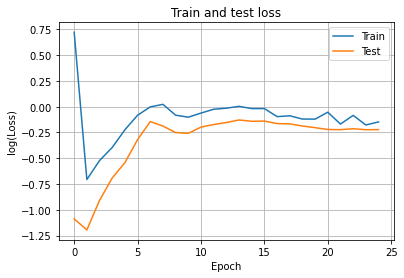

In [23]:
plt.plot(np.log(train_stat['train_loss']))
plt.plot(np.log(train_stat['test_loss']))
plt.grid()
plt.legend(['Train', 'Test'])
plt.title('Train and test loss')
plt.xlabel('Epoch')
plt.ylabel('log(Loss)')
plt.show()

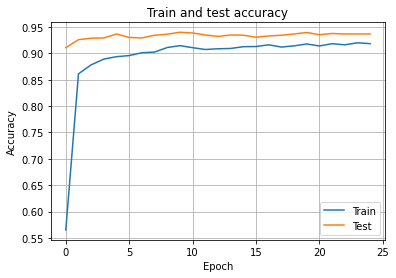

In [24]:
plt.plot(train_stat['train_acc'])
plt.plot(train_stat['test_acc'])
plt.grid()
plt.legend(['Train', 'Test'])
plt.title('Train and test accuracy')
plt.xlabel('Epoch')
plt.ylabel('Accuracy')
plt.show()

Судя по графикам выше, переобучение не наблюдается.
Далее проведем тесты модели на кросс-валидации, чтобы убедиться, что высокие показатели Accuracy на тестовой выборке не связаны с конкретным выбором данных для тестирования

In [29]:
hyperparams = Namespace()
hyperparams.finetune = True
hyperparams.lr = 0.002
hyperparams.momentum = 1.0
hyperparams.step_size = 7
hyperparams.gamma = 0.1
hyperparams.epoch_count = 20
hyperparams.log_comment = f"ResNet152 with RandHorizontalFlip(p=0.9) and RandAugment transform applied to original dataset (EXPANDED train dataset)"

cv_report = Namespace()
cv_report.best_models = []
cv_report.train_stats = []
cv_report.time = None
cv_report.train_dataset_sizes = []
cv_report.test_dataset_sizes = []
cv_report.best_acc_per_fold = []
cv_report.best_epoch_per_fold = []


logger.info('[CROSSVAL LOOP] Start cross validation')
cv_start_time = time.time()

for fold_idx in range(K_FOLD):
    logger.info(f"[CROSSVAL LOOP] Start iteration {fold_idx}/{K_FOLD}")
    train_source = os.path.join(CROSS_VAL_DATA, f'fold_{fold_idx}', 'train')
    test_source = os.path.join(CROSS_VAL_DATA, f'fold_{fold_idx}', 'test')
    train_data = datasets.ImageFolder(root=train_source, transform=transform_dict['train'])
    test_data = datasets.ImageFolder(root=test_source, transform=transform_dict['test'])
    augmented_data = datasets.ImageFolder(root=train_source, transform=transform_dict['augment'])
    train_and_augmented_data = ConcatDataset([train_data, augmented_data])

    train_loader = torch.utils.data.DataLoader(train_and_augmented_data, batch_size=BATCH_SIZE, shuffle=True, drop_last=False, num_workers=4)
    test_loader = torch.utils.data.DataLoader(test_data, batch_size=BATCH_SIZE, shuffle=True, drop_last=False, num_workers=4)
    
    dataloaders = {
        'train': train_loader,
        'test': test_loader,
    }
    hyperparams.model = models.resnet152(pretrained=True)
    model = Model(hyperparams, dataloaders)
    best_model, train_stat = model.train()
    
    cv_report.best_models.append(model)
    cv_report.train_stats.append(train_stat)
    cv_report.train_dataset_sizes.append(len(train_data))
    cv_report.test_dataset_sizes.append(len(test_data))
    cv_report.best_acc_per_fold.append(train_stat['best_acc'])
    cv_report.best_epoch_per_fold.append(train_stat['best_epoch'])
    
    logger.info("[CROSSVAL LOOP] Fold: {}/{}\tTrain time: {:.0f}m {:.0f}s\tBest epoch: {}\tBest acc: {}".format(
        fold_idx,
        K_FOLD,
        train_stat['time'] // 60,
        train_stat['time'] % 60,
        train_stat['best_epoch'],
        train_stat['best_acc'],
    ))
    
time_elapsed = time.time() - cv_start_time
cv_report.time = time_elapsed
logger.info(f"[CROSSVAL LOOP] End cross validation with mean acc: {np.mean(cv_report.best_acc_per_fold)}")

print('Training complete in {:.0f}m {:.0f}s'.format(time_elapsed // 60, time_elapsed % 60))
print('Mean test Acc: {:4f}'.format(np.mean(cv_report.best_acc_per_fold)))

100%|██████████| 20/20 [17:13<00:00, 51.68s/it]


Training complete in 17m 14s
Best test Acc: 0.948390


100%|██████████| 20/20 [17:24<00:00, 52.20s/it]


Training complete in 17m 24s
Best test Acc: 0.932287


100%|██████████| 20/20 [17:25<00:00, 52.26s/it]

Training complete in 17m 25s
Best test Acc: 0.932817
Training complete in 52m 5s
Mean test Acc: 0.937831


Кросс-валидация показала, что в среднем модель гарантирует `Accuracy` выше 0.93 независимо от тестовой выборки.
Далее обучим нашу модель на всей выборке и получим предсказания для валидационной выборки. Оптимальные параметры и оптимальное количество эпох было найдено выше (см. графики и выводы).

In [41]:
image_names = validate_loader.dataset.samples
image_names = [i[0] for i in image_names]

hyperparams = Namespace()
hyperparams.model = models.resnet152(pretrained=True)
hyperparams.finetune = True
hyperparams.lr = 0.002
hyperparams.momentum = 1.0
hyperparams.step_size = 7
hyperparams.gamma = 0.1
hyperparams.epoch_count = 20
hyperparams.log_comment = f"ResNet152 with RandHorizontalFlip(p=0.9) and RandAugment transform applied to original dataset (EXPANDED train dataset)"

dataloaders = {
    'train': nonsplitted_loader,
    'test': nonsplitted_loader
}

model = Model(hyperparams, dataloaders)

_, train_stat = model.train(test_phase=False)
pred_lst = model.predict(validate_loader)
pred_lst = [i.item() for i in pred_lst]

100%|██████████| 20/20 [20:47<00:00, 62.39s/it]

Training complete in 20m 48s
Best test Acc: 0.000000


Полученные предсказания сохраняем в `lab_2_part_5_res.csv` файл

In [51]:
import pandas as pd

res_df = pd.DataFrame({
    'file_name': image_names,
    'predicted_label': pred_lst
})

res_df.to_csv('lab_2_part_5_res.csv')